In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

plt.rcParams.update({'font.size': 8})

def label_subplots_ABC(fig, axs, x_shift, y_shift, start_idx=0, **text_kws):
    labels = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'][start_idx:]
    if type(x_shift) != list():
        x_shift = [x_shift] * len(axs)
    if type(y_shift) != list():
        y_shift = [y_shift] * len(axs)
    for i, ax in enumerate(axs):
        # Get the position of the subplot
        pos = ax.get_position()  # returns (left, bottom, width, height)

        # Annotate at the upper-left corner of each subplot
        fig.text(pos.x0 + x_shift[i], pos.y1 + y_shift[i], labels[i], **text_kws)   

In [2]:
ls network_data/numpy_arrays/

morph_1_current_mean.npy  morph_2_current_mean.npy  no_morph_current_mean.npy
morph_1_current_sem.npy   morph_2_current_sem.npy   no_morph_current_sem.npy
morph_1_fr_mean.npy       morph_2_fr_mean.npy       no_morph_fr_mean.npy
morph_1_fr_sem.npy        morph_2_fr_sem.npy        no_morph_fr_sem.npy


In [3]:
labels=['morph_1', 'morph_2', 'no_morph']
fr_mean = [np.load(''.join(['network_data/numpy_arrays/', l, '_fr_mean.npy'])) for l in labels]
fr_sem = [np.load(''.join(['network_data/numpy_arrays/', l, '_fr_sem.npy'])) for l in labels]
cu_mean = [np.load(''.join(['network_data/numpy_arrays/', l, '_current_mean.npy'])) for l in labels]
cu_sem = [np.load(''.join(['network_data/numpy_arrays/', l, '_current_sem.npy'])) for l in labels]
# dimensions encode 3 stimulator radii [50, 150, 250], time, and space

In [4]:
fr_mean[0].shape

(3, 30, 80)

In [5]:
dx_fr = 40 # um
dt_fr = 5 #ms
x_fr = np.arange(0,fr_mean[0].shape[2]*dx_fr, dx_fr)
t_fr = np.arange(0,fr_mean[0].shape[1]*dt_fr, dt_fr)
dx_cu = 2 #um
dt_cu = 1 #ms
x_cu = np.arange(0,cu_mean[0].shape[2]*dx_cu, dx_cu)
t_cu = np.arange(0,cu_mean[0].shape[1]*dt_cu, dt_cu)

# calc r50
def find_half_max_x(x, y):

    y_max = max(y)
    half_max = y_max / 2
    
    # Find the index where the y-value is closest to the half-max
    closest_index = np.argmin(np.abs(np.array(y) - half_max))
    
    # Get the value at the closest index
    closest_y = y[closest_index]
    
    # If the closest value is equal to half-max, return it
    if closest_y == half_max:
        return x[closest_index]

    # Interpolate if the closest value is not exactly half-max
    if closest_y > half_max:  # Interpolate between the closest index and the next one
        if closest_index + 1 < len(y):
            x0, y0 = x[closest_index], y[closest_index]
            x1, y1 = x[closest_index + 1], y[closest_index + 1]
            # Linear interpolation
            x_half_max = x0 + (half_max - y0) * (x1 - x0) / (y1 - y0)
            return x_half_max
    else:  # Interpolate between the closest index and the previous one
        if closest_index - 1 >= 0:
            x0, y0 = x[closest_index], y[closest_index]
            x1, y1 = x[closest_index - 1], y[closest_index - 1]
            # Linear interpolation
            x_half_max = x0 + (half_max - y0) * (x1 - x0) / (y1 - y0)
            return x_half_max
    
r50 = {'output':dict(), 'input':dict()}
for il, label in enumerate(labels):
    r50['input'][label]  = dict()
    r50['output'][label] = dict()
    for ir, radius in enumerate([50,150]):
        r50['input'][label][radius]  = find_half_max_x(x_cu, cu_mean[il][ir].mean(axis=0))
        r50['output'][label][radius] = find_half_max_x(x_fr, fr_mean[il][ir].mean(axis=0))

In [6]:
def plot_response(main, inset1, inset2, resp_t_x, sem_t_x, dx, dt, plot_time_resp_at_um=200, 
                  main_kws={}, inset1_kws={}, inset2_kws={}, 
                  sbar_inset_draw=False, inset_title=False):
    x = np.arange(0,resp_t_x.shape[1]*dx, dx)
    t = np.arange(0,resp_t_x.shape[0]*dt, dt)
    resp_tmean = resp_t_x.mean(axis=0)
    sem_tmean = sem_t_x.mean(axis=0)
    main.plot(x, resp_tmean, **main_kws)
    main_kws_wo_label = new_dict = {k: v for k, v in main_kws.items() if k != 'label'}
    main.fill_between(x, resp_tmean-sem_tmean, resp_tmean+sem_tmean, alpha=0.2, **main_kws_wo_label)
    resp_center = resp_t_x[:,0]
    resp_middle = resp_t_x[:,int(plot_time_resp_at_um/dx)]
    inset1.plot(t, resp_center/resp_center.max(), **inset1_kws)
    inset2.plot(t, resp_middle/resp_middle.max(), **inset2_kws)
    
    main.set_xlim(0,500)
    main.spines['top'].set_visible(False)
    main.spines['right'].set_visible(False)
    for ax in [inset1, inset2]:
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
    if sbar_inset_draw:    
        # Add two scalebars forming a corner using rectangle patches
        for ax, sb_ly in zip([inset1, inset2], [int((np.max(resp_center)*0.4)/2)*2,int((np.max(resp_middle)*0.4)/2)*2]):
            scale_length_x = 20 #ms
            #scale_length_y = sb_ly #Hz
            x_start, y_start = ax.get_xlim()[0], ax.get_ylim()[0]
            y_length = ax.get_ylim()[1] - ax.get_ylim()[0]
            rect_x = patches.Rectangle((x_start, y_start), scale_length_x, 0, linewidth=2, edgecolor='black', facecolor='black')
            #rect_y = patches.Rectangle((x_start, y_start), 0, scale_length_y, linewidth=2, edgecolor='black', facecolor='black')    
            ax.add_patch(rect_x)
            #ax.add_patch(rect_y)
            # Add labels for scalebars
            ax.text(x_start + scale_length_x / 2, y_start - 0.05*y_length, '  '+str(scale_length_x)+' ms', 
                           ha='center', va='top', fontsize=8, color='black')
            #ax.text(x_start - 0.5, y_start + scale_length_y / 2, '  '+str(scale_length_y)+' Hz', 
            #               ha='right', va='center', fontsize=8, color='black', rotation=90)
    if inset_title:
        inset1.set_title('Response @0µm', loc='left', fontsize=8)
        inset2.set_title('@200µm', loc='left', fontsize=8)

    return main, inset1, inset2

def get_insets(fig, main):
    # Get position of the main plot
    pos = main.get_position()
    inset_width = pos.width * 0.4
    inset_height = pos.height * 0.2
    inset_bottom = pos.y0 + pos.height + 0.01
    # Inset subplots above main plot
    inset1 = fig.add_axes([pos.x0+pos.width*0.1, inset_bottom, inset_width, inset_height])
    inset2 = fig.add_axes([pos.x0+pos.width*0.15+inset_width, inset_bottom, inset_width, inset_height])
    return inset1, inset2

/tmp/ipykernel_76438/1377488833.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


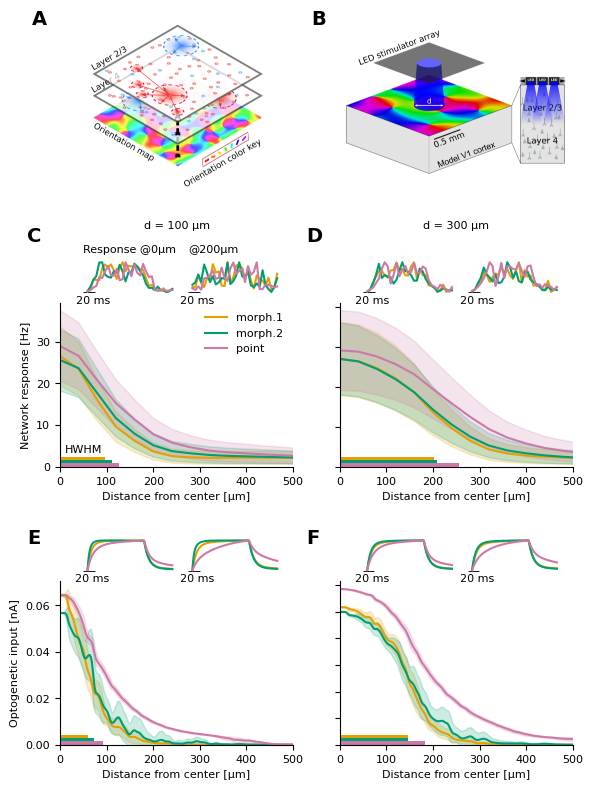

In [8]:
a4_w, a4_h = 8.27, 11.69
fig, axs = plt.subplots(3, 2, figsize=(a4_w*0.8, a4_h*0.8), gridspec_kw={'hspace': 0.7})

# import sketches on upper panels:
axs[0, 0].axis('off')  # Upper left
axs[0, 1].axis('off')  # Upper right
axs[0, 0].imshow(mpimg.imread('/home/david/Documents/papers/reduction_paper/model_V1.png'))
axs[0, 1].imshow(mpimg.imread('/home/david/Documents/papers/reduction_paper/stimulator_model.png'))

colors = []
for ir, stim_radius in enumerate([50,150]):
    main1 = axs[1, ir]
    inset11, inset12 = get_insets(fig, main=main1)
    main2 = axs[2, ir]
    inset21, inset22 = get_insets(fig, main=main2)
    for il, (label, sb_draw, inset_title, c) in enumerate(zip(['morph.1', 'morph.2',   'point'],
                                                              [    False,     False,      True],
                                                              [     True,     False,     False],
                                                              ['#E69F00', '#009E73', '#CC79A7']
                                                              )):
        colors.append(c)
        main, inset1, inset2 = plot_response(
            main=main1,
            inset1=inset11,
            inset2=inset12,
            resp_t_x=fr_mean[il][ir],
            sem_t_x=fr_sem[il][ir],
            dx=dx_fr, 
            dt=dt_fr, 
            plot_time_resp_at_um=200, 
            main_kws=dict(label=label, color=c), 
            inset1_kws=dict(color=c), 
            inset2_kws=dict(color=c),
            sbar_inset_draw=sb_draw,
            inset_title=inset_title*(ir==0)
        )
        main, inset1, inset2 = plot_response(
            main=main2,
            inset1=inset21,
            inset2=inset22,
            resp_t_x=cu_mean[il][ir], 
            sem_t_x=cu_sem[il][ir],
            dx=dx_cu, 
            dt=dt_cu, 
            plot_time_resp_at_um=200, 
            main_kws=dict(label=label, color=c), 
            inset1_kws=dict(color=c), 
            inset2_kws=dict(color=c),
            sbar_inset_draw=sb_draw
        )

axs[1,0].set_ylabel('Network response [Hz]')
axs[1,1].set_yticklabels([])
axs[2,0].set_ylabel('Optogenetic input [nA]')
axs[2,1].set_yticklabels([])
for ax in axs[1:,:].flatten():
    ax.set_xlabel('Distance from center [µm]')
    ax.set_ylim(bottom=0)
axs[1,0].legend(frameon=False)

for irow, in_out in enumerate(['output', 'input']):
    irow+=1
    for ir, radius in enumerate([50,150]):
        bar_widths = [r50[in_out][label][radius] for label in labels]
        #for width, color in zip(bar_widths, colors): 
        #    axs[irow,ir].axvline(width, color=color)
        ymin, ymax = axs[irow,ir].get_ylim()
        ywidth = (ymax - ymin) * 0.02
        bar_y = [ymin+ywidth/2, ymin+ywidth*3/2, ymin+ywidth*5/2][::-1]  # Relative y positions, very close to 0, to stack over the x-axis
        if irow==1 and ir ==0:
            axs[irow, ir].text(10, bar_y[1]*2.5, "HWHM", va='bottom')
        
        # Add bars using the transformed coordinates
        for i, (width, color) in enumerate(zip(bar_widths, colors)):
            axs[irow,ir].barh(bar_y[i], width, color=color, height=ywidth)

axs[1,0].set_title('d = 100 µm', fontsize=8, y=1.4)
axs[1,1].set_title('d = 300 µm', fontsize=8, y=1.4)
label_subplots_ABC(fig=fig, axs=axs.flatten()[:2], x_shift=-0.05, y_shift=0, fontsize=14, fontweight='bold')
label_subplots_ABC(fig=fig, axs=axs.flatten()[2:4], start_idx=2, x_shift=-0.05, y_shift=+0.065, fontsize=14, fontweight='bold')
label_subplots_ABC(fig=fig, axs=axs.flatten()[4:], start_idx=4, x_shift=-0.05, y_shift=+0.04, fontsize=14, fontweight='bold')

fig.savefig('article_figure_network.png', dpi=600)
fig.show()